## Learning problem - portfolio optimization

In [1]:
import numpy as np
import numpy.random as npr
import numpy.testing as npt
import scipy as sc
import torch
import cvxpy as cp
import matplotlib.pyplot as plt

# from tests.settings import SOLVER
from sklearn.model_selection import train_test_split

from lropt.parameter import Parameter
from lropt.robust_problem import RobustProblem
from lropt.uncertain import UncertainParameter
from lropt.uncertainty_sets.ellipsoidal import Ellipsoidal
import warnings
warnings.filterwarnings('ignore')

We consider the classic portfolio management problem where we select a portfolio $x \in \reals^n$ of stocks to maximize returns. Our selected stock should not deviate too far from our previous holdings, denoted $x^{\text{prev}} \in \reals^n$. The trading cost of the total deviations is $0.2\|x - x^{\text{prev}}\|_1$.

We model returns as $u$, and thus the objective to minimize is 
$$-u^Tx + 0.2\|x - x^{\text{prev}}\|_1.$$
To account for uncertainty in the returns $u$, we introduce a new variable $t$ to write the objective in epigraph form, obtaining the RO problem 
\begin{equation*}
	\begin{array}{ll}
		\text{minimize} & t + 0.2\|x - x^{\text{prev}}\|_1\\
		\text{subject to} & -u^Tx \le t \quad \forall u \in \mathcal{U}(\theta) \\
		& 1^Tx = 1, \quad x \geq 0.
	\end{array}
\end{equation*}

We generate the uncertain demand $u$ from a Normal distribution, with parameters
\begin{equation*}
	\mu =
\left[ \begin{array}{l} 0.3 \\
0.3 \end{array} \right],\quad \Sigma =
\left[\begin{array}{ll} \phantom{-}0.5 & -0.3\\
-0.3 & \phantom{-}0.4 \end{array} \right].
\end{equation*}

In [2]:
def gen_demand_intro(N, seed):
    """
    This function generates random demand.
    """
    np.random.seed(seed)
    sig = np.array([[0.5, -0.3], [-0.3, 0.4]])
    mu = np.array((0.3, 0.3))
    d_train = np.random.multivariate_normal(mu, sig, N)
    # d_train = np.exp(d_train)
    return d_train

n = 2
N = 100
data = gen_demand_intro(600, seed=15)

We parametrize the optimization problem by $y = x^{\text{prev}}$, the previous holdings.
We consider the parameter $y$ with finite support; in particular, we consider 10 possible values of $y$.
To enforce holdings summing up to $1$, we set each instance of the previous holdings $x^{\text{prev}}$ using the Dirichlet distribution, with parameter value $(2.5,1)$, corresponding to the 2 different stocks.

In [3]:
np.random.seed(15)
dist = np.array((2.5,1.0))
y_data = np.random.dirichlet(dist, 10)
y = Parameter(n, data=y_data)

We then create the robust problem.

In [4]:
u = UncertainParameter(n,uncertainty_set=Ellipsoidal(p=2,data=data))

x = cp.Variable(n)
t = cp.Variable()

objective = cp.Minimize(t + 0.2*cp.norm(x - y, 1))
constraints = [-x@u <= t, cp.sum(x) == 1, x >= 0]
eval_exp = -x @ u + 0.2*cp.norm(x-y, 1)
prob = RobustProblem(objective, constraints, eval_exp=eval_exp)

Next, we initialize the mean-variance uncertainty set, as well as the training problem. We run the algorithm for 100 iterations, and obtain the reshaped sets, A_fin and b_fin

In [9]:
kappa = -0.01
test_p = 0.1
# split the data into train and test
train, _ = train_test_split(data, test_size=int(
    data.shape[0]*test_p), random_state=5)

# formulate the mean-variance set using the training data
init = sc.linalg.sqrtm(sc.linalg.inv(0.0001*np.eye(2) + np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)

# generating a random init
# np.random.seed(15)
# initn = np.random.rand(n, n) + 0.1*init + 0.5*np.eye(n)
# init_bvaln = -initn@(np.mean(train, axis=0) - 0.3*np.ones(n))

result = prob.train(lr=0.0001, num_iter=100, momentum=0.8,
                            optimizer="SGD",
                            seed=5, init_A=init, init_b=init_bval,
                            init_lam=0.5, init_mu=0.01,
                            mu_multiplier=1.001, init_alpha=0., test_percentage=test_p, kappa=kappa,
                            n_jobs=8, random_init=True, num_random_init=5, parallel = True, position=False)
A_fin = result.A
b_fin = result.b

run 2: test value N/A, violations N/A:   0%|          | 0/100 [00:00<?, ?it/s]/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_s/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause cra

We now show the pareto curve of the out-of-sample objective value vs. the probability of constraint violation for the mean-variance and reshpaed sets.

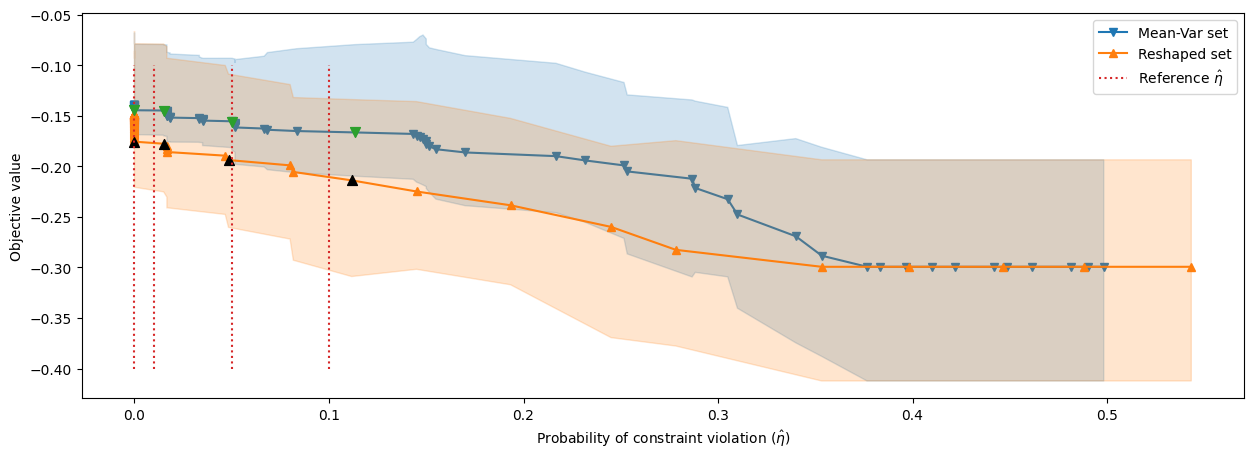

In [10]:
eps_list = np.linspace(0.0001, 4, 100)

# Grid search epsilon
result4 = prob.grid(epslst=eps_list, init_A=init,
                    init_b=init_bval, seed=8,
                    init_alpha=0., test_percentage=test_p, quantiles = (0.4, 0.6))
dfgrid = result4.df

result5 = prob.grid(epslst=eps_list, init_A=A_fin, init_b=b_fin, seed=8,
                    init_alpha=0., test_percentage=test_p,quantiles = (0.4,0.6))
dfgrid2 = result5.df

prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Probability_violations_test']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Probability_violations_test']),axis = 1)-i).argmin())
st_eps = eps_list[inds_standard[0]]
re_eps = eps_list[inds_reshaped[0]]
beg1, end1 = 0, 2000
beg2, end2 = 0, 2000
plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(dfgrid['Probability_violations_test']), axis=1)[beg1:end1], np.mean(np.vstack(
    dfgrid['Test_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
plt.fill(np.append(dfgrid['Probability_violations_test'][beg1:end1],dfgrid['Probability_violations_test'][beg1:end1][::-1]), np.append(dfgrid['Lower_test'][beg1:end1],dfgrid['Upper_test'][beg1:end1][::-1]), color="tab:blue", alpha=0.2)
for ind in range(4):
    plt.scatter(np.mean(np.vstack(dfgrid['Probability_violations_test']), axis=1)[inds_standard[ind]], np.mean(np.vstack(
        dfgrid['Test_val']), axis=1)[inds_standard[ind]], color="tab:green", s=50, marker="v", zorder=10)
plt.plot(np.mean(np.vstack(dfgrid2['Probability_violations_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid2['Test_val']), axis=1)[beg2:end2], color="tab:orange", label="Reshaped set", marker="^", zorder=1)
plt.fill(np.append(dfgrid2['Probability_violations_test'][beg2:end2],dfgrid2['Probability_violations_test'][beg2:end2][::-1]), np.append(dfgrid2['Lower_test'][beg2:end2],dfgrid2['Upper_test'][beg2:end2][::-1]), color="tab:orange", alpha=0.2)
for ind in [0, 2, 1, 3]:
    plt.scatter(np.mean(np.vstack(dfgrid2['Probability_violations_test']), axis=1)[inds_reshaped[ind]], np.mean(
        np.vstack(dfgrid2['Test_val']), axis=1)[inds_reshaped[ind]], color="black", s=50, marker="^")
plt.ylabel("Objective value")
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
minv, maxv = (-0.25,-0.1)
minv, maxv = (-0.4,-0.1)
plt.vlines(ymin=minv, ymax=maxv, x=prob_list[0], linestyles=":",
           color="tab:red", label="Reference $\hat{\eta}$")
for i in prob_list[1:]:
    plt.vlines(ymin=minv, ymax=maxv, x=i, linestyles=":", color="tab:red")
plt.legend()
plt.show()
# plt.savefig("portlinear_objective_vs_violations.pdf", bbox_inches='tight')